# ResNet-18(sMRI)


Train Set Diagnostics:
Shapes: X=torch.Size([7034, 1, 145, 145]), y=torch.Size([7034])
Class balance: 0.5000
Data range: X ∈ [0.00, 0.95]
NaN values: X=False, y=False


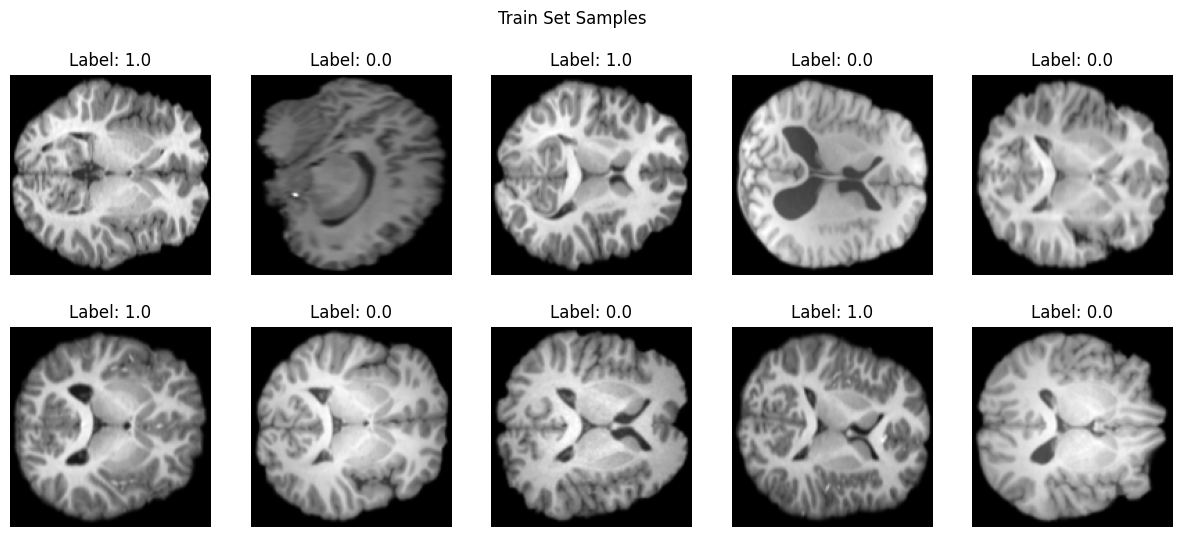


Validation Set Diagnostics:
Shapes: X=torch.Size([1508, 1, 145, 145]), y=torch.Size([1508])
Class balance: 0.5000
Data range: X ∈ [0.00, 0.95]
NaN values: X=False, y=False


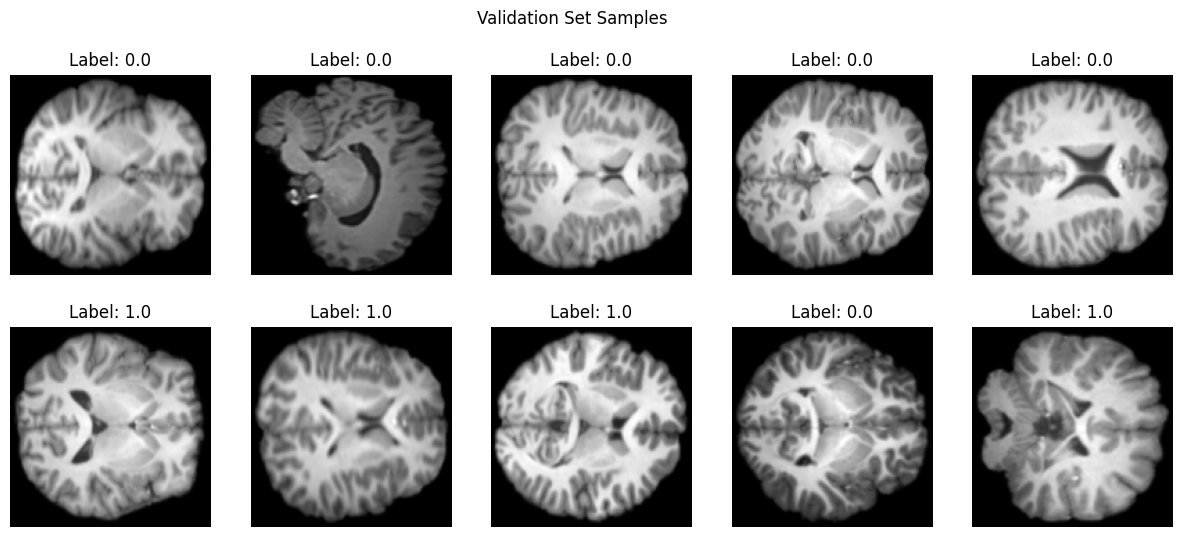


Test Set Diagnostics:
Shapes: X=torch.Size([1508, 1, 145, 145]), y=torch.Size([1508])
Class balance: 0.5000
Data range: X ∈ [0.00, 0.94]
NaN values: X=False, y=False


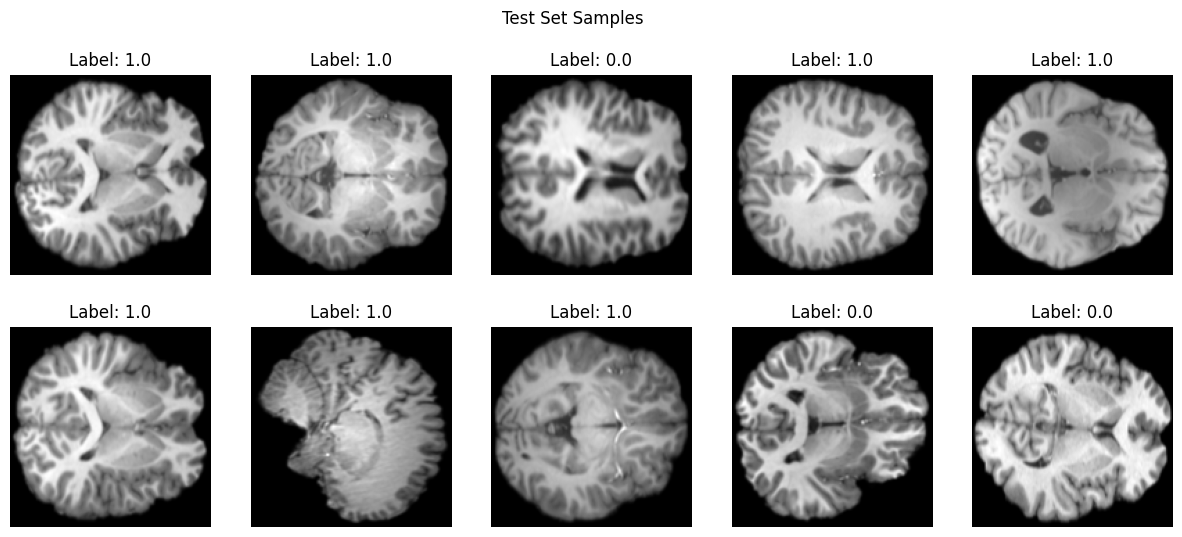

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Updated Model Architecture (SMRIExpertClassifier):
SMRIExpertClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(6

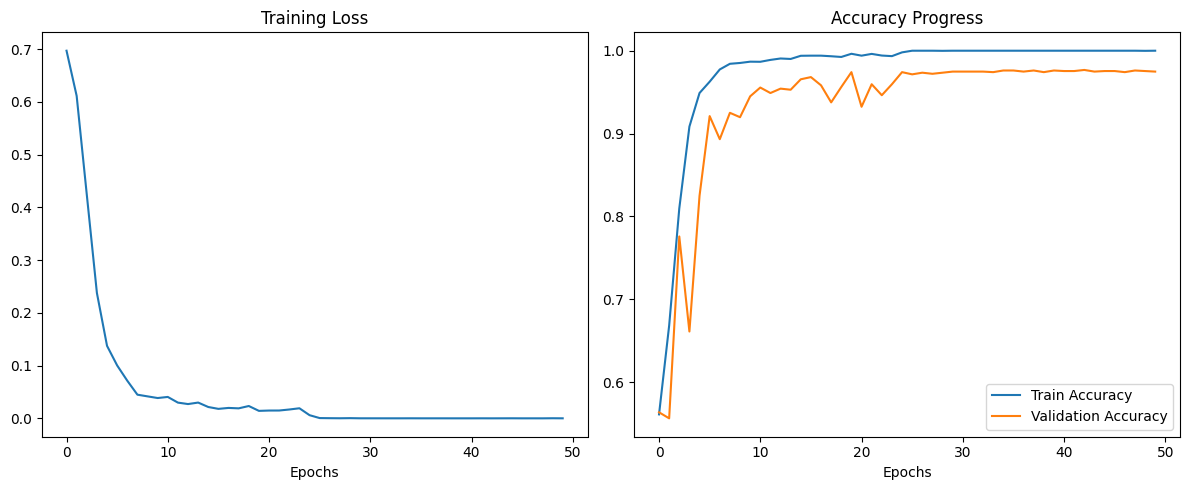

In [11]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# --- CONFIG ---
DATA_DIR = r"/kaggle/input/equaldatasetsmrifmri-2d/dataset_splits_sMRI/dataset_splits"
BATCH_SIZE = 64
EPOCHS = 50
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- Updated Model Definition ---
class SMRIExpertClassifier(nn.Module):
    """
    ResNet-18 backbone + embedding head + classifier head for 2D sMRI slices.
    """
    def __init__(self, embedding_dim=512, num_classes=1, dropout_prob=0.5):
        super().__init__()
        # Load pretrained ResNet18 and remove its final FC
        backbone = resnet18(pretrained=True)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        feat_dim = backbone.fc.in_features
        
        # Embedding projection
        self.embed = nn.Linear(feat_dim, embedding_dim)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Linear(embedding_dim, num_classes)
        )

    def forward(self, x):
        # If single-channel, convert to 3-channel by replication
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        
        # Feature extraction
        f = self.features(x).flatten(1)       # (B, feat_dim)
        e = self.embed(f)                     # (B, embedding_dim)
        logits = self.classifier(e).squeeze(1)  # (B,)
        return logits

# --- Data Helper ---
def load_split(name):
    X_path = os.path.join(DATA_DIR, name, f"X_{name}.npy")
    y_path = os.path.join(DATA_DIR, name, f"y_{name}.npy")
    
    X = np.load(X_path)
    y = np.load(y_path)
    
    # Add channel dimension and convert to tensor
    X = torch.tensor(X.transpose(0, 3, 1, 2), dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    
    return X, y

# --- Data Diagnostics ---
def check_data_sanity(X, y, name):
    print(f"\n{name} Set Diagnostics:")
    print(f"Shapes: X={X.shape}, y={y.shape}")
    print(f"Class balance: {y.mean().item():.4f}")
    print(f"Data range: X ∈ [{X.min():.2f}, {X.max():.2f}]")
    print(f"NaN values: X={torch.isnan(X).any()}, y={torch.isnan(y).any()}")
    
    # Plot sample images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for idx, ax in enumerate(axes.flat):
        img = X[idx][0].cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Label: {y[idx].item()}")
        ax.axis('off')
    plt.suptitle(f"{name} Set Samples")
    plt.show()

# --- Training Setup ---
def initialize_model(train_loader):
    model = SMRIExpertClassifier().to(DEVICE)
    
    # Class weighting for imbalance
    y_train = train_loader.dataset.tensors[1]
    pos_weight = torch.tensor([(len(y_train) - y_train.sum()) / y_train.sum()])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(DEVICE))
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.2, patience=3, verbose=True
    )
    
    return model, criterion, optimizer, scheduler

# --- Training Loop ---
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs):
    best_acc = 0
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
    patience = 70
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        all_preds, all_labels = [], []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = accuracy_score(all_labels, all_preds)
        
        val_acc, conf_matrix = evaluate_model(model, val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        scheduler.step(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"  Val Acc: {val_acc:.4f}")
        print(f"  Confusion Matrix:\n{conf_matrix}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_smri_expert.pth')
            patience = 70
        else:
            patience -= 1
        
        if patience <= 0:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    model.load_state_dict(torch.load('best_smri_expert.pth'))
    return model, history

# --- Evaluation ---
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return acc, conf_matrix

# --- Main Execution ---
if __name__ == "__main__":
    # Load data
    X_train, y_train = load_split('train')
    X_val, y_val = load_split('val')
    X_test, y_test = load_split('test')
    
    # Data sanity checks
    check_data_sanity(X_train, y_train, 'Train')
    check_data_sanity(X_val, y_val, 'Validation')
    check_data_sanity(X_test, y_test, 'Test')
    
    # Create dataloaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), 
                              batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), 
                            batch_size=BATCH_SIZE, pin_memory=True)
    
    # Initialize and inspect model
    model, criterion, optimizer, scheduler = initialize_model(train_loader)
    print("\nUpdated Model Architecture (SMRIExpertClassifier):")
    print(model)
    
    # Train
    trained_model, history = train_model(
        model, criterion, optimizer, scheduler,
        train_loader, val_loader, EPOCHS
    )
    
    # Final evaluation
    test_acc, test_conf = evaluate_model(
        trained_model, DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE)
    )
    print(f"\nFinal Test Accuracy: {test_acc:.4f}")
    print(f"Test Confusion Matrix:\n{test_conf}")
    
    # Plot history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title("Accuracy Progress")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Model's Evaluation 

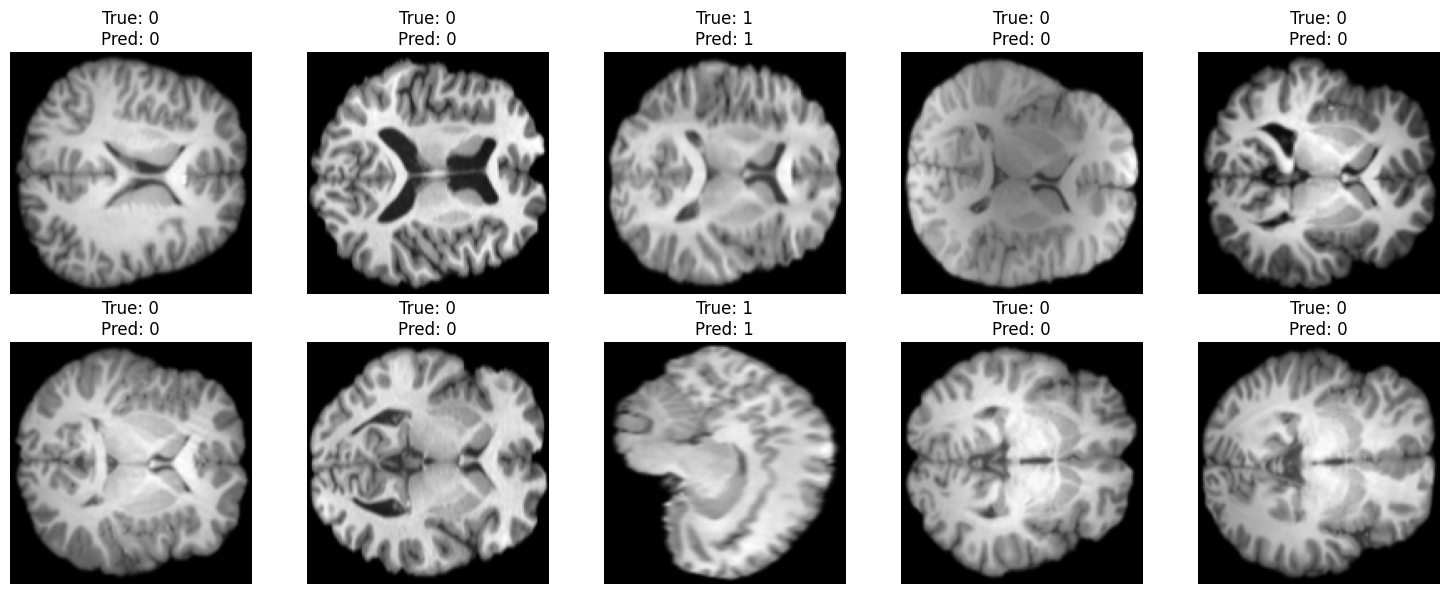

In [12]:
import random
import torch
import matplotlib.pyplot as plt

def visualize_predictions(model, test_dataset, device, num_samples=10):
    """
    Randomly samples `num_samples` from `test_dataset`, runs the model on them,
    and plots each image with its actual vs. predicted label.
    
    Args:
        model (nn.Module): trained SMRIExpertClassifier
        test_dataset (TensorDataset): contains (X, y) for test split
        device (torch.device): cuda or cpu
        num_samples (int): how many examples to display
    """
    model.eval()
    # pick random indices
    indices = random.sample(range(len(test_dataset)), num_samples)
    
    # set up the plot grid
    cols = min(num_samples, 5)
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten()
    
    with torch.no_grad():
        for ax, idx in zip(axes, indices):
            x, y_true = test_dataset[idx]
            x_input = x.unsqueeze(0).to(device)                # add batch dim
            logits = model(x_input)                            # (1,)
            y_pred = (torch.sigmoid(logits) > 0.5).item()      # bool → 0/1
            
            # prepare image for plotting
            img = x.cpu().squeeze()                            # (C,H,W) → (H,W) if C=1
            if img.ndim == 3:
                img = img[0]                                   # take first channel
            
            ax.imshow(img, cmap="gray")
            ax.set_title(f"True: {int(y_true.item())}\nPred: {int(y_pred)}")
            ax.axis("off")
    
    # hide any extra axes
    for ax in axes[num_samples:]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# --- Usage example (at the bottom of your script) ---

if __name__ == "__main__":
    # ... after loading X_test, y_test and training your model ...
    
    from torch.utils.data import TensorDataset
    
    # recreate your test dataset and loader
    test_dataset = TensorDataset(X_test, y_test)
    
    # visualize 10 random predictions
    visualize_predictions(trained_model, test_dataset, DEVICE, num_samples=10)


# ResNet-18 (fMRI)


Train Set Diagnostics:
Shapes: X=torch.Size([7034, 1, 145, 145]), y=torch.Size([7034])
Class balance: 0.5000
Data range: X ∈ [0.00, 0.91]
NaN values: X=False, y=False


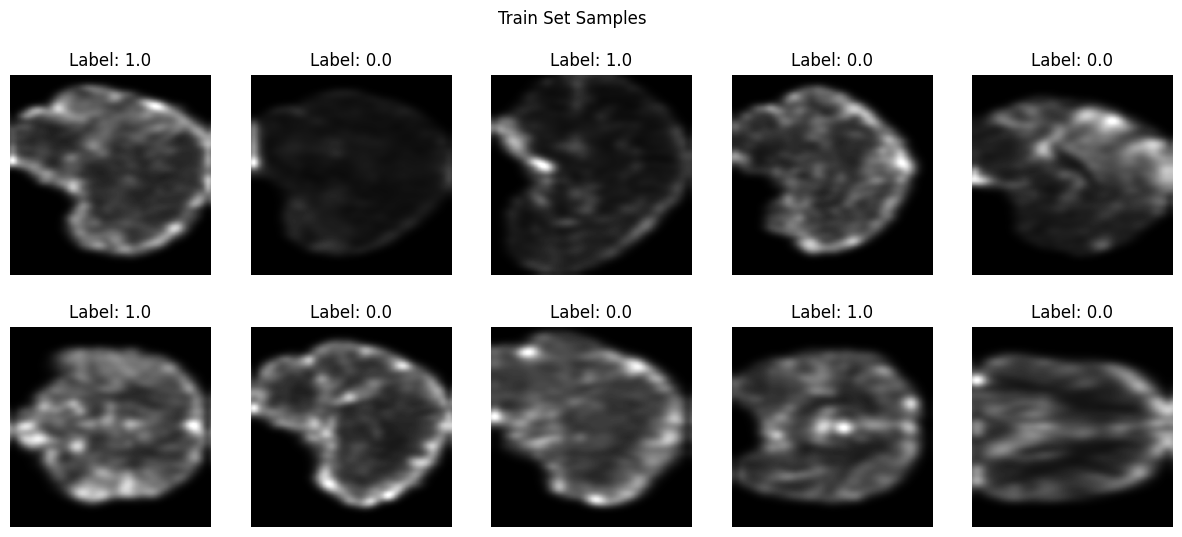


Validation Set Diagnostics:
Shapes: X=torch.Size([1508, 1, 145, 145]), y=torch.Size([1508])
Class balance: 0.5000
Data range: X ∈ [0.00, 0.91]
NaN values: X=False, y=False


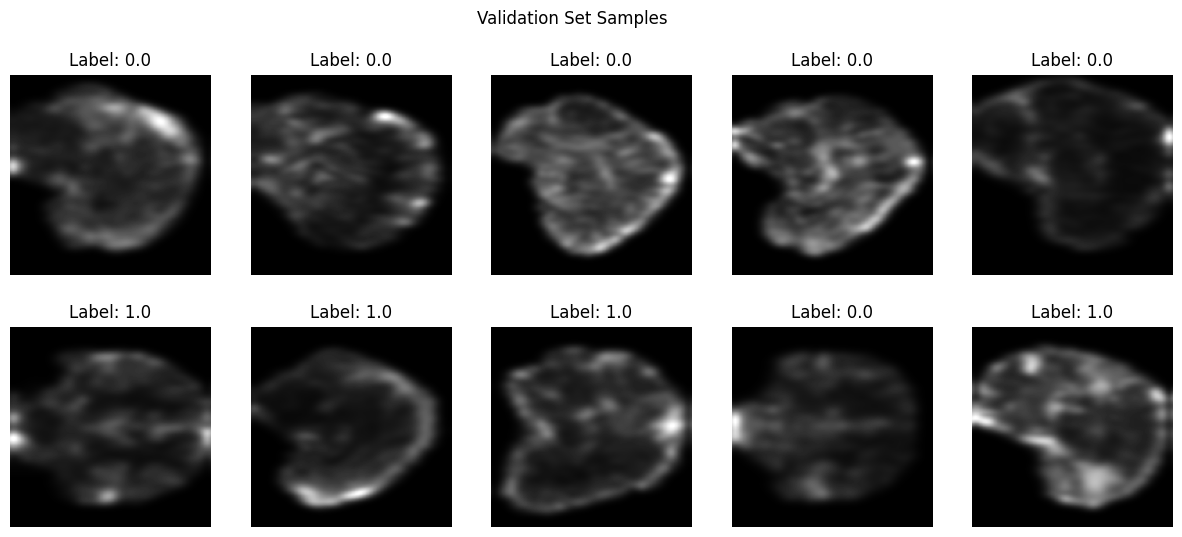


Test Set Diagnostics:
Shapes: X=torch.Size([1508, 1, 145, 145]), y=torch.Size([1508])
Class balance: 0.5000
Data range: X ∈ [0.00, 0.84]
NaN values: X=False, y=False


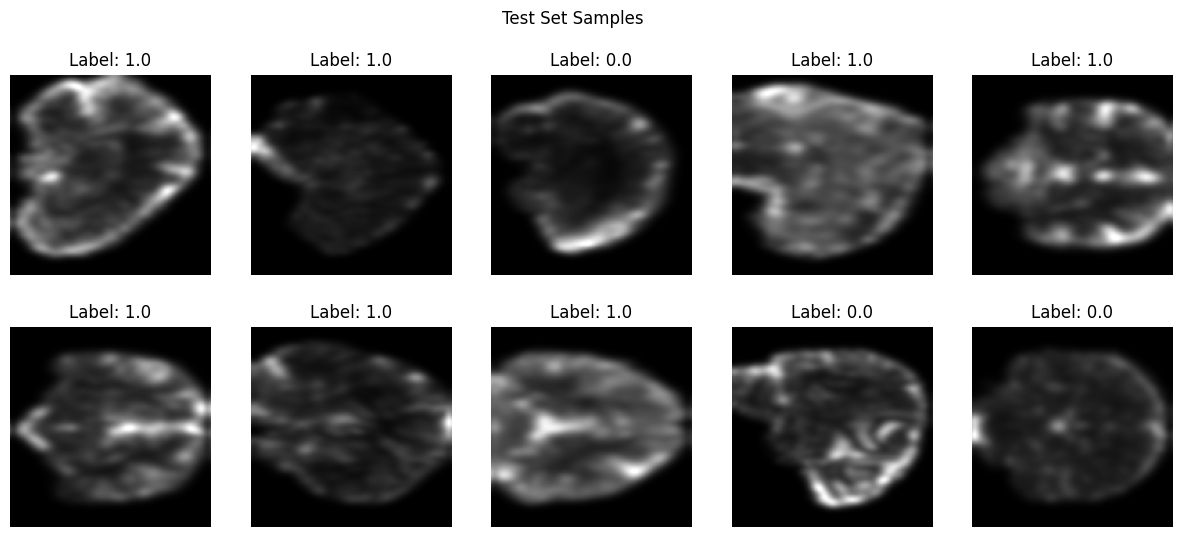

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



SMRIExpertClassifier Architecture:
 SMRIExpertClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, m

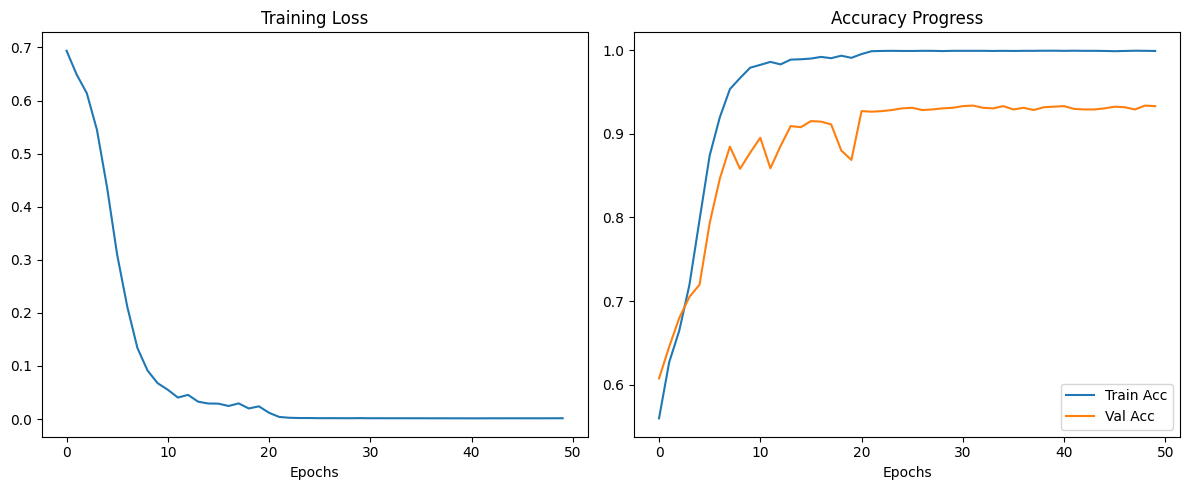

In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# --- CONFIG ---
DATA_DIR = r"/kaggle/input/equaldatasetsmrifmri-2d/dataset_splits_fMRI/dataset_splits"
BATCH_SIZE = 64
EPOCHS = 50
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- sMRI Model Definition ---
class SMRIExpertClassifier(nn.Module):
    """
    ResNet-18 backbone + embedding head + classifier head for 2D fMRI slices.
    """
    def __init__(self, embedding_dim=512, num_classes=1, dropout_prob=0.5):
        super().__init__()
        # Load pretrained ResNet18 and strip off its final FC
        backbone = resnet18(pretrained=True)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        feat_dim = backbone.fc.in_features
        
        # Embedding projection
        self.embed = nn.Linear(feat_dim, embedding_dim)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Linear(embedding_dim, num_classes)
        )

    def forward(self, x):
        # Convert 1-channel → 3-channel if needed
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        
        # Feature extraction
        f = self.features(x).flatten(1)        # (B, feat_dim)
        e = self.embed(f)                      # (B, embedding_dim)
        logits = self.classifier(e).squeeze(1) # (B,)
        return logits

# --- Data Helper for sMRI ---
def load_split(name: str):
    X_path = os.path.join(DATA_DIR, name, f"X_{name}.npy")
    y_path = os.path.join(DATA_DIR, name, f"y_{name}.npy")
    X = np.load(X_path)  # shape (N, H, W, C)
    y = np.load(y_path)  # shape (N,)
    # to torch: (N, C, H, W)
    X = torch.tensor(X.transpose(0, 3, 1, 2), dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return X, y

# --- Data Diagnostics (optional) ---
def check_data_sanity(X, y, name):
    print(f"\n{name} Set Diagnostics:")
    print(f"Shapes: X={X.shape}, y={y.shape}")
    print(f"Class balance: {y.mean().item():.4f}")
    print(f"Data range: X ∈ [{X.min():.2f}, {X.max():.2f}]")
    print(f"NaN values: X={torch.isnan(X).any()}, y={torch.isnan(y).any()}")
    # Plot sample images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for idx, ax in enumerate(axes.flat):
        img = X[idx][0].cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Label: {y[idx].item()}")
        ax.axis('off')
    plt.suptitle(f"{name} Set Samples")
    plt.show()

# --- Training Setup ---
def initialize_model(train_loader):
    model = SMRIExpertClassifier().to(DEVICE)
    # Class weighting for imbalance
    y_train = train_loader.dataset.tensors[1]
    pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(DEVICE))
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.2, patience=3, verbose=True
    )
    return model, criterion, optimizer, scheduler

# --- Training Loop ---
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, epochs):
    best_acc, patience = 0.0, 70
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = accuracy_score(all_labels, all_preds)
        val_acc, conf_matrix = evaluate_model(model, val_loader)
        scheduler.step(val_acc)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"[Epoch {epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        
        if val_acc > best_acc:
            best_acc, patience = val_acc, 70
            torch.save(model.state_dict(), 'best_fmri_expert.pth')
        else:
            patience -= 1
            if patience == 0:
                print("Early stopping.")
                break
    
    model.load_state_dict(torch.load('best_fmri_expert.pth'))
    return model, history

# --- Evaluation ---
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    acc = accuracy_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return acc, conf_matrix

# --- Main Execution ---
if __name__ == "__main__":
    # Load data splits
    X_train, y_train = load_split('train')
    X_val, y_val     = load_split('val')
    X_test, y_test   = load_split('test')
    
    # (Optional) sanity checks
    check_data_sanity(X_train, y_train, 'Train')
    check_data_sanity(X_val, y_val,     'Validation')
    check_data_sanity(X_test, y_test,   'Test')
    
    # Create dataloaders
    train_loader = DataLoader(
        TensorDataset(X_train, y_train),
        batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True
    )
    val_loader = DataLoader(
        TensorDataset(X_val, y_val),
        batch_size=BATCH_SIZE, pin_memory=True
    )
    
    # Initialize model, loss, optimizer, scheduler
    model, criterion, optimizer, scheduler = initialize_model(train_loader)
    print("\nSMRIExpertClassifier Architecture:\n", model)
    
    # Train
    trained_model, history = train_model(
        model, criterion, optimizer, scheduler,
        train_loader, val_loader, EPOCHS
    )
    
    # Test
    test_acc, test_conf = evaluate_model(
        trained_model,
        DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE)
    )
    print(f"\nFinal Test Accuracy: {test_acc:.4f}")
    print(f"Test Confusion Matrix:\n{test_conf}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title("Accuracy Progress")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Model's Evaluation 

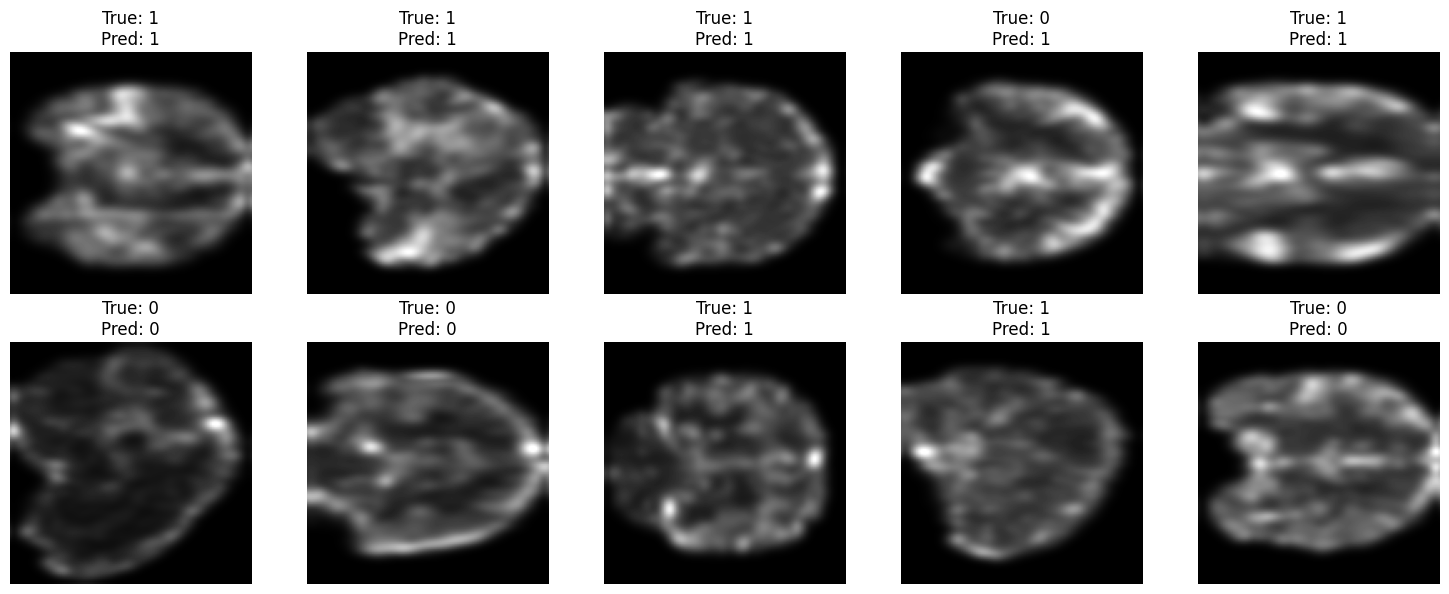

In [14]:
import random
import torch
import matplotlib.pyplot as plt

def visualize_predictions(model, test_dataset, device, num_samples=10):
    """
    Randomly samples `num_samples` from `test_dataset`, runs the model on them,
    and plots each image with its actual vs. predicted label.
    
    Args:
        model (nn.Module): trained SMRIExpertClassifier
        test_dataset (TensorDataset): contains (X, y) for test split
        device (torch.device): cuda or cpu
        num_samples (int): how many examples to display
    """
    model.eval()
    # pick random indices
    indices = random.sample(range(len(test_dataset)), num_samples)
    
    # set up the plot grid
    cols = min(num_samples, 5)
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten()
    
    with torch.no_grad():
        for ax, idx in zip(axes, indices):
            x, y_true = test_dataset[idx]
            x_input = x.unsqueeze(0).to(device)                # add batch dim
            logits = model(x_input)                            # (1,)
            y_pred = (torch.sigmoid(logits) > 0.5).item()      # bool → 0/1
            
            # prepare image for plotting
            img = x.cpu().squeeze()                            # (C,H,W) → (H,W) if C=1
            if img.ndim == 3:
                img = img[0]                                   # take first channel
            
            ax.imshow(img, cmap="gray")
            ax.set_title(f"True: {int(y_true.item())}\nPred: {int(y_pred)}")
            ax.axis("off")
    
    # hide any extra axes
    for ax in axes[num_samples:]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# --- Usage example (at the bottom of your script) ---

if __name__ == "__main__":
    # ... after loading X_test, y_test and training your model ...
    
    from torch.utils.data import TensorDataset
    
    # recreate your test dataset and loader
    test_dataset = TensorDataset(X_test, y_test)
    
    # visualize 10 random predictions
    visualize_predictions(trained_model, test_dataset, DEVICE, num_samples=10)


# Fusion 

In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix

# --- CONFIG ---
SMRI_DATA_DIR     = r"/kaggle/input/equaldatasetsmrifmri-2d/dataset_splits_sMRI/dataset_splits"
FMRI_DATA_DIR     = r"/kaggle/input/equaldatasetsmrifmri-2d/dataset_splits_fMRI/dataset_splits"
SMRI_WEIGHTS_PATH = "best_smri_expert.pth"
FMRI_WEIGHTS_PATH = "best_fmri_expert.pth"

BATCH_SIZE = 32
EPOCHS     = 20
LR         = 1e-4
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- DATA LOADING ---
def load_split(data_dir, split):
    X = np.load(os.path.join(data_dir, split, f"X_{split}.npy"))  # (N,H,W,C)
    y = np.load(os.path.join(data_dir, split, f"y_{split}.npy"))  # (N,)
    X = torch.tensor(X.transpose(0,3,1,2), dtype=torch.float32)   # (N,C,H,W)
    y = torch.tensor(y, dtype=torch.float32)                      # (N,)
    return X, y

# load smri and fmri splits
X_tr_s, y_tr_s = load_split(SMRI_DATA_DIR, 'train')
X_val_s, y_val_s = load_split(SMRI_DATA_DIR, 'val')
X_te_s, y_te_s = load_split(SMRI_DATA_DIR, 'test')

X_tr_f, y_tr_f = load_split(FMRI_DATA_DIR, 'train')
X_val_f, y_val_f = load_split(FMRI_DATA_DIR, 'val')
X_te_f, y_te_f = load_split(FMRI_DATA_DIR, 'test')

# ensure labels align
assert torch.equal(y_tr_s, y_tr_f), "Train labels mismatch!"
assert torch.equal(y_val_s, y_val_f), "Val labels mismatch!"
assert torch.equal(y_te_s, y_te_f), "Test labels mismatch!"

# create paired datasets
train_ds = TensorDataset(X_tr_s, X_tr_f, y_tr_s)
val_ds   = TensorDataset(X_val_s, X_val_f, y_val_s)
test_ds  = TensorDataset(X_te_s, X_te_f, y_te_s)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,             pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE,             pin_memory=True)

# --- EXPERT MODELS (load pretrained weights) ---
class SMRIExpertClassifier(nn.Module):
    def __init__(self, emb_dim=512):
        super().__init__()
        backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        feat_dim = backbone.fc.in_features
        self.embed = nn.Linear(feat_dim, emb_dim)
        self.classifier = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(emb_dim, 1)
        )

    def forward(self, x):
        # expand grayscale to RGB if needed
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        f = self.features(x).flatten(1)
        e = self.embed(f)
        return self.classifier(e).squeeze(1)

class FMRIExpertClassifier(nn.Module):
    def __init__(self, emb_dim=512):
        super().__init__()
        backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        feat_dim = backbone.fc.in_features
        self.embed = nn.Linear(feat_dim, emb_dim)
        self.classifier = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(emb_dim, 1)
        )

    def forward(self, x):
        # expand grayscale to RGB if needed
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
        f = self.features(x).flatten(1)
        e = self.embed(f)
        return self.classifier(e).squeeze(1)

# load experts
smri_expert = SMRIExpertClassifier().to(DEVICE)
smri_expert.load_state_dict(torch.load(SMRI_WEIGHTS_PATH, map_location=DEVICE))
fmri_expert = FMRIExpertClassifier().to(DEVICE)
fmri_expert.load_state_dict(torch.load(FMRI_WEIGHTS_PATH, map_location=DEVICE))

# --- FUSION MODEL ---
class BiModalTokenTransformer(nn.Module):
    def __init__(self, emb_dim=512, layers=2, heads=4, dropout=0.1):
        super().__init__()
        self.type_emb = nn.Parameter(torch.randn(2, emb_dim))
        encoder = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder, num_layers=layers)

    def forward(self, e1, e2):
        tokens = torch.stack([e1, e2], dim=1)       # (B,2,emb_dim)
        tokens = tokens + self.type_emb.unsqueeze(0)
        out = self.transformer(tokens)              # (B,2,emb_dim)
        return out[:,0], out[:,1]

class DualFrozenFusionModel(nn.Module):
    def __init__(self, smri_exp, fmri_exp, emb_dim=512, gate_h=128):
        super().__init__()
        self.smri_exp = smri_exp
        self.fmri_exp = fmri_exp
        # freeze all expert weights
        for p in self.smri_exp.parameters(): p.requires_grad = False
        for p in self.fmri_exp.parameters(): p.requires_grad = False

        self.bmt  = BiModalTokenTransformer(emb_dim)
        self.gate = nn.Sequential(
            nn.Linear(2*emb_dim, gate_h),
            nn.ReLU(inplace=True),
            nn.Linear(gate_h, 2),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(emb_dim, emb_dim//2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(emb_dim//2, 1)
        )

    def forward(self, x_s, x_f):
        # ensure 3-channel for ResNet
        if x_s.shape[1] == 1:
            x_s = x_s.repeat(1, 3, 1, 1)
        if x_f.shape[1] == 1:
            x_f = x_f.repeat(1, 3, 1, 1)

        # get embeddings
        f1 = self.smri_exp.features(x_s.to(DEVICE)).flatten(1)
        e1 = self.smri_exp.embed(f1)
        f2 = self.fmri_exp.features(x_f.to(DEVICE)).flatten(1)
        e2 = self.fmri_exp.embed(f2)

        # multimodal fusion
        t1, t2 = self.bmt(e1, e2)
        cat    = torch.cat([t1, t2], dim=1)
        g1, g2 = self.gate(cat).chunk(2, dim=1)
        fused  = g1 * t1 + g2 * t2

        return self.classifier(fused).squeeze(1)

# instantiate fusion model
fusion_model = DualFrozenFusionModel(smri_expert, fmri_expert).to(DEVICE)

# --- TRAINING LOOP ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(fusion_model.parameters(), lr=LR)
best_val_acc = 0.0

for epoch in range(1, EPOCHS+1):
    fusion_model.train()
    running_loss = 0.0
    for batch_i, (xs, xf, y) in enumerate(train_loader, 1):
        xs, xf, y = xs.to(DEVICE), xf.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        logits = fusion_model(xs, xf)
        loss   = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_i % 10 == 0 or batch_i == len(train_loader):
            avg_loss = running_loss / batch_i
            print(f"[Epoch {epoch}/{EPOCHS}] Batch {batch_i}/{len(train_loader)} — "
                  f"Loss: {avg_loss:.4f}")

    # validation
    fusion_model.eval()
    preds, labs = [], []
    with torch.no_grad():
        for xs, xf, y in val_loader:
            xs, xf = xs.to(DEVICE), xf.to(DEVICE)
            y = y.to(DEVICE)
            out = fusion_model(xs, xf)
            p   = (torch.sigmoid(out) > 0.5).float()
            preds.extend(p.cpu().tolist())
            labs.extend(y.cpu().tolist())

    val_acc = accuracy_score(labs, preds)
    val_conf = confusion_matrix(labs, preds)
    print(f"→ Validation Acc after epoch {epoch}: {val_acc:.4f}")
    print(f"Confusion Matrix:\n{val_conf}\n")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(fusion_model.state_dict(), 'best_fusion_model.pth')
        print(f"*** Saved new best model (Acc {best_val_acc:.4f}) ***\n")

# --- TEST EVALUATION ---
fusion_model.load_state_dict(torch.load('best_fusion_model.pth', map_location=DEVICE))
fusion_model.eval()
test_preds, test_labs = [], []
with torch.no_grad():
    for xs, xf, y in test_loader:
        xs, xf = xs.to(DEVICE), xf.to(DEVICE)
        y = y.to(DEVICE)
        out = fusion_model(xs, xf)
        p   = (torch.sigmoid(out) > 0.5).float()
        test_preds.extend(p.cpu().tolist())
        test_labs.extend(y.cpu().tolist())

test_acc = accuracy_score(test_labs, test_preds)
test_conf = confusion_matrix(test_labs, test_preds)
print(f"*** Final Test Acc: {test_acc:.4f} ***")
print(f"Test Confusion Matrix:\n{test_conf}")


[Epoch 1/20] Batch 10/220 — Loss: 0.1985
[Epoch 1/20] Batch 20/220 — Loss: 0.1013
[Epoch 1/20] Batch 30/220 — Loss: 0.0678
[Epoch 1/20] Batch 40/220 — Loss: 0.0510
[Epoch 1/20] Batch 50/220 — Loss: 0.0409
[Epoch 1/20] Batch 60/220 — Loss: 0.0341
[Epoch 1/20] Batch 70/220 — Loss: 0.0293
[Epoch 1/20] Batch 80/220 — Loss: 0.0257
[Epoch 1/20] Batch 90/220 — Loss: 0.0228
[Epoch 1/20] Batch 100/220 — Loss: 0.0206
[Epoch 1/20] Batch 110/220 — Loss: 0.0187
[Epoch 1/20] Batch 120/220 — Loss: 0.0172
[Epoch 1/20] Batch 130/220 — Loss: 0.0159
[Epoch 1/20] Batch 140/220 — Loss: 0.0147
[Epoch 1/20] Batch 150/220 — Loss: 0.0138
[Epoch 1/20] Batch 160/220 — Loss: 0.0129
[Epoch 1/20] Batch 170/220 — Loss: 0.0122
[Epoch 1/20] Batch 180/220 — Loss: 0.0115
[Epoch 1/20] Batch 190/220 — Loss: 0.0115
[Epoch 1/20] Batch 200/220 — Loss: 0.0110
[Epoch 1/20] Batch 210/220 — Loss: 0.0114
[Epoch 1/20] Batch 220/220 — Loss: 0.0109
→ Validation Acc after epoch 1: 0.9794
Confusion Matrix:
[[732  22]
 [  9 745]]

*** 

# Model's Evaluation 

Test Accuracy over 1508 samples: 0.9874


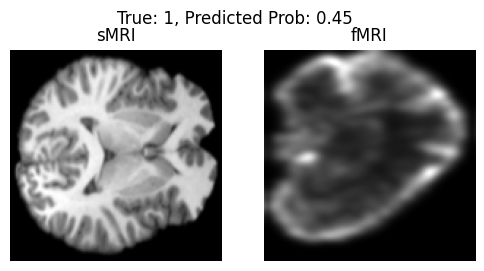

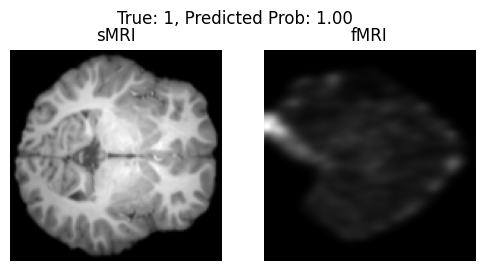

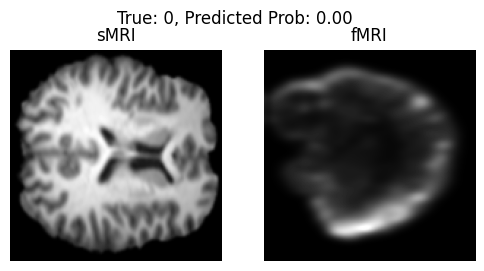

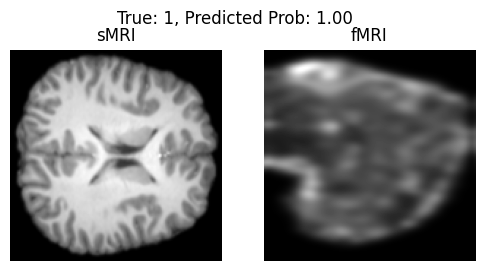

In [16]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

# --- ASSUMES fusion_model, DEVICE, SMRI_DATA_DIR, FMRI_DATA_DIR ARE DEFINED ---

# 1. Load test splits
X_te_s = np.load(os.path.join(SMRI_DATA_DIR, 'test', 'X_test.npy'))  # shape: (N, H, W, C)
y_te   = np.load(os.path.join(SMRI_DATA_DIR, 'test', 'y_test.npy'))  # shape: (N,)
X_te_f = np.load(os.path.join(FMRI_DATA_DIR, 'test', 'X_test.npy'))

# 2. Convert to torch tensors
X_te_s_t = torch.tensor(X_te_s.transpose(0,3,1,2), dtype=torch.float32)
X_te_f_t = torch.tensor(X_te_f.transpose(0,3,1,2), dtype=torch.float32)
y_te_t   = torch.tensor(y_te, dtype=torch.float32)

# 3. DataLoader
test_ds     = TensorDataset(X_te_s_t, X_te_f_t, y_te_t)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# 4. Compute overall accuracy
fusion_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xs, xf, y in test_loader:
        xs, xf, y = xs.to(DEVICE), xf.to(DEVICE), y.to(DEVICE)
        # expand 1→3 channels
        if xs.shape[1] == 1: xs = xs.repeat(1,3,1,1)
        if xf.shape[1] == 1: xf = xf.repeat(1,3,1,1)
        logits = fusion_model(xs, xf)
        preds  = (torch.sigmoid(logits) > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy over {len(all_labels)} samples: {accuracy:.4f}")

# 5. Visualize a few samples
sample_idxs = [0, 1, 2, 3]
for i in sample_idxs:
    img_s = X_te_s[i]
    img_f = X_te_f[i]
    true  = y_te[i]

    # prepare single-batch tensors
    xs = torch.tensor(img_s.transpose(2,0,1), dtype=torch.float32).unsqueeze(0)
    xf = torch.tensor(img_f.transpose(2,0,1), dtype=torch.float32).unsqueeze(0)
    if xs.shape[1] == 1: xs = xs.repeat(1,3,1,1)
    if xf.shape[1] == 1: xf = xf.repeat(1,3,1,1)
    xs, xf = xs.to(DEVICE), xf.to(DEVICE)

    with torch.no_grad():
        prob = torch.sigmoid(fusion_model(xs, xf)).cpu().item()

    # plot
    fig, axes = plt.subplots(1, 2, figsize=(6,3))
    axes[0].imshow(img_s.squeeze(), cmap='gray')
    axes[0].set_title('sMRI')
    axes[0].axis('off')
    axes[1].imshow(img_f.squeeze(), cmap='gray')
    axes[1].set_title('fMRI')
    axes[1].axis('off')
    fig.suptitle(f"True: {true}, Predicted Prob: {prob:.2f}")
    plt.show()
